# XAI Analysis Feature Comparison Notebook

---
## 1. Setup and Library Imports

In [23]:
import pandas as pd
import os
import joblib
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Libraries imported successfully.")

Libraries imported successfully.


## 2. Load Assets
Load the necessary assets: the test data, the champion model, and the fitted SHAP explainer.

In [24]:
# --- Load Data ---
try:
    df1 = pd.read_csv('data/phishing_dataset_ml_full.csv')
    if 'id' in df1.columns: df1 = df1.drop('id', axis=1)
    X = df1.drop('CLASS_LABEL', axis=1)
    y = df1['CLASS_LABEL']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    print("Test data loaded and prepared successfully.")
except FileNotFoundError:
    print("Error: Dataset file not found. Please ensure it exists in the 'data' directory.")

# --- Load Champion Model (48 Features) ---
try:
    champion_model_48 = joblib.load('models/url_model_ds1.joblib')
    print("Champion model (48 features) loaded.")
except FileNotFoundError:
    print("Error: Champion model not found. Please ensure you have run the training notebook first.")

Test data loaded and prepared successfully.
Champion model (48 features) loaded.


## 3. Experiment: Baseline Features vs. All Features
Based on the source paper for this dataset, a subset of 10 "baseline" features achieved very high accuracy when compared to other more advanced models. We will test this by training a new Random Forest model on only these 10 features and comparing its performance and explanations.

In [26]:
# Define the 10 baseline features from the research paper
baseline_features = [
    'PctExtHyperlinks', 'PctExtResourceUrls', 'PctNullSelfRedirectHyperlinks',
    'FrequentDomainNameMismatch', 'SubmitInfoToEmail', 'AbnormalFormAction',
    'SubdomainLevelRT', 'UrlLengthRT', 'PctExtResourceUrlsRT', 'AbnormalExtFormActionR'
]
local_baseline_features = [
    'PctExtHyperlinks', 'PctExtNullSelfRedirectHyperlinksRT', 'FrequentDomainNameMismatch',
    'PctNullSelfRedirectHyperlinks', 'PctExtResourceUrls', 'NumDash', 'InsecureForms',
    'NumNumericChars', 'PathLevel', 'SubmitInfoToEmail', 'ExtMetaScriptLinkRT',
    'NumQueryComponents', 'NumDots', 'NumSensitiveWords'
]

# Create new training and testing sets with only the baseline features
X_train_10 = X_train[baseline_features]
X_test_10 = X_test[baseline_features]
# Create new training and testing sets with only the local baseline features
X_train_14 = X_train[local_baseline_features]
X_test_14 = X_test[local_baseline_features]

# Train a new Random Forest model on the 10 baseline features
print("\nTraining new model on 10 baseline features...")
champion_model_10 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
champion_model_10.fit(X_train_10, y_train)
print("New model trained successfully.")

# Train a new Random Forest model on the 14 local baseline features
print("\nTraining new model on 10 baseline features...")
champion_model_14 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
champion_model_14.fit(X_train_14, y_train)
print("New model trained successfully.")

# Compare accuracies
y_pred_48 = champion_model_48.predict(X_test)
y_pred_10 = champion_model_10.predict(X_test_10)
y_pred_14 = champion_model_14.predict(X_test_14)
acc_48 = accuracy_score(y_test, y_pred_48)
acc_10 = accuracy_score(y_test, y_pred_10)
acc_14 = accuracy_score(y_test, y_pred_14)

print(f"\nAccuracy of model with 48 features: {acc_48:.4f}")
print(f"Accuracy of model with 10 features: {acc_10:.4f}")
print(f"Accuracy of model with 14 features: {acc_14:.4f}")

model_performance = {
    "rf_48": [
        acc_48, precision_score(y_test, y_pred_48),
        recall_score(y_test, y_pred_48), f1_score(y_test, y_pred_48)
    ],
    "rf_10": [
        acc_10, precision_score(y_test, y_pred_10),
        recall_score(y_test, y_pred_10), f1_score(y_test, y_pred_10)
    ],
    "rf_14": [
        acc_14, precision_score(y_test, y_pred_14),
        recall_score(y_test, y_pred_14), f1_score(y_test, y_pred_14)
    ]
}

showdown_df = pd.DataFrame.from_dict(
    model_performance,
    orient='index',
    columns=['Accuracy', 'Precision', 'Recall', 'F1-Score']
)
display(showdown_df)


Training new model on 10 baseline features...
New model trained successfully.

Training new model on 10 baseline features...
New model trained successfully.

Accuracy of model with 48 features: 0.9855
Accuracy of model with 10 features: 0.9625
Accuracy of model with 14 features: 0.9825


,Accuracy,Precision,Recall,F1-Score
rf_48,0.9855,0.985986,0.985,0.985493
rf_10,0.9625,0.949466,0.977,0.963036
rf_14,0.9825,0.984925,0.980,0.982456


## 4. Create SHAP Explainers and Calculate Values for Both Models

In [28]:
# --- Explainer for 48-feature model ---
print("\nCreating SHAP explainer for 48-feature model...")
explainer_48 = shap.TreeExplainer(champion_model_48, X_train)
shap_explanation_48 = explainer_48(X_test)
print("SHAP values for 48-feature model created.")

# --- Explainer for 10-feature model ---
print("\nCreating SHAP explainer for 10-feature model...")
explainer_10 = shap.TreeExplainer(champion_model_10, X_train_10)
shap_explanation_10 = explainer_10(X_test_10)
print("SHAP values for 10-feature model created.")

# --- Explainer for 14-feature model ---
print("\nCreating SHAP explainer for 14-feature model...")
explainer_14 = shap.TreeExplainer(champion_model_14, X_train_14)
shap_explanation_14 = explainer_14(X_test_14)
print("SHAP values for 14-feature model created.")


Creating SHAP explainer for 48-feature model...


100%|===================| 3985/4000 [01:22<00:00]        

SHAP values for 48-feature model created.

Creating SHAP explainer for 10-feature model...


 99%|===================| 3960/4000 [01:04<00:00]        

SHAP values for 10-feature model created.

Creating SHAP explainer for 14-feature model...


 99%|===================| 3958/4000 [01:14<00:00]        

SHAP values for 14-feature model created.


## 5. Compare Global Feature Importance
We can now directly compare which features each model found most important.


--- Generating SHAP Bar Plot Comparison ---
--- 48 feature RandomForestClassifier ---


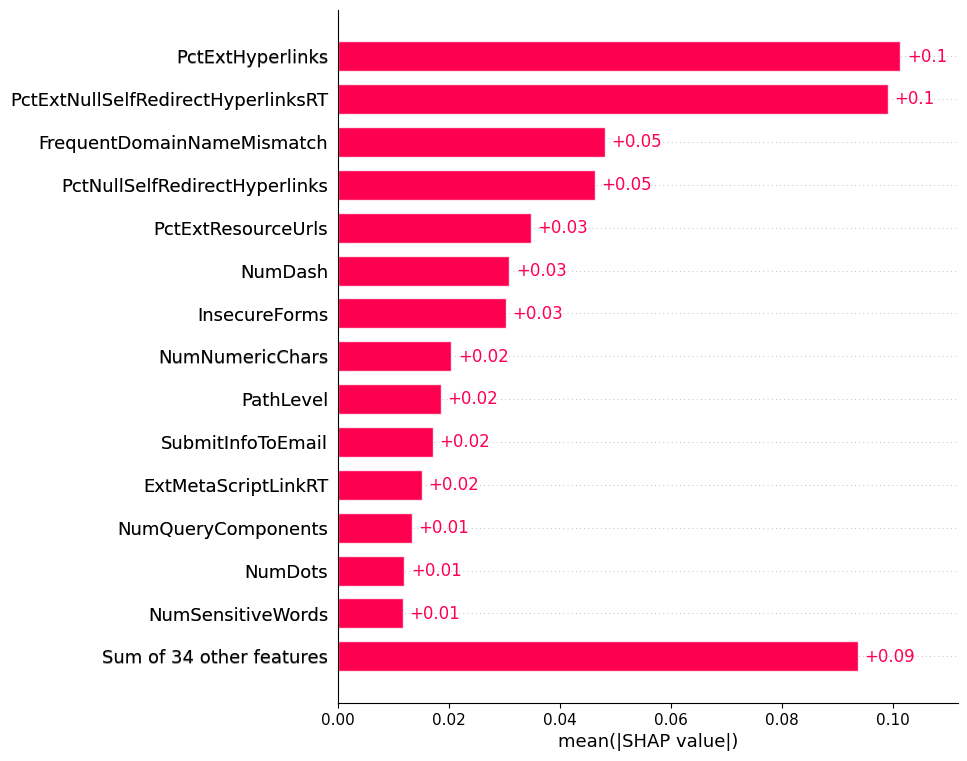


--- 10 feature RandomForestClassifier ---


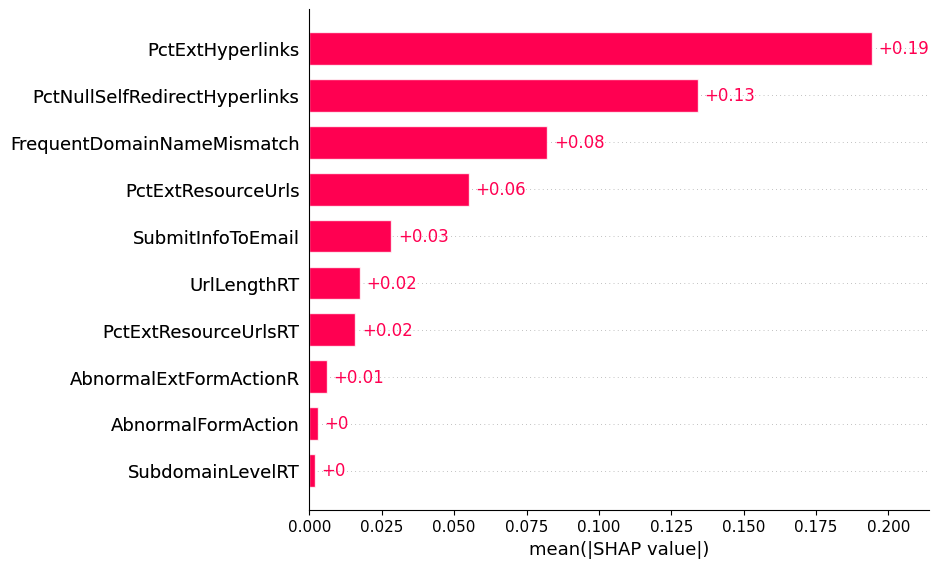


--- 14 feature RandomForestClassifier ---


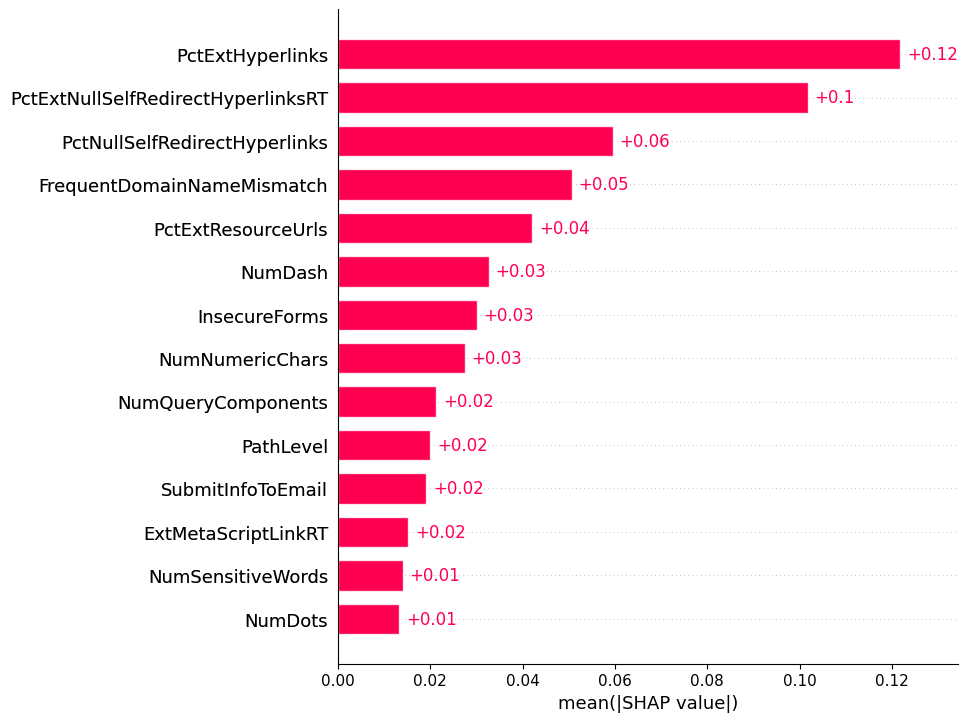


Champion model has been serialized to 'models/url_model_ds114.joblib'

SHAP explainer has been serialized to 'models/url_explainer_ds114.joblib'


In [39]:
# --- Bar Plots ---
print("\n--- Generating SHAP Bar Plot Comparison ---")
print("--- 48 feature RandomForestClassifier ---")
shap.plots.bar(shap_explanation_48[:,:,1], max_display=15)

print("\n--- 10 feature RandomForestClassifier ---")
shap.plots.bar(shap_explanation_10[:,:,1], max_display=10)

print("\n--- 14 feature RandomForestClassifier ---")
shap.plots.bar(shap_explanation_14[:,:,1], max_display=15)

if not os.path.exists('models'):
    os.makedirs('models')
# Save the model
joblib.dump(champion_model_14, 'models/url_model_ds114.joblib')
print("\nChampion model has been serialized to 'models/url_model_ds114.joblib'")
# Save the explainer
joblib.dump(explainer_14, 'models/url_explainer_ds114.joblib')
print("\nSHAP explainer has been serialized to 'models/url_explainer_ds114.joblib'")

## Conclusion
The RandomForest model with full 48 features from the dataset outperforms the model with the 10 features specified by Chiew, Kang Leng, et al. in their [reserch paper](https://www.sciencedirect.com/science/article/abs/pii/S0020025519300763?via%3Dihub) *A new hybrid ensemble feature selection framework for machine learning-based phishing detection system*.  The extracted local features from the performance of the local model in the general [Explainable Analysis](/xai_analysis.ipynb) of the model.  The resulting 14 feature model has a comparable result to the full 48 feature model.  The result is a 0.3% difference in accuracy, 0.1% difference in precission, 0.5% difference in recall, and 0.3% difference in f1 score with a 70.8% feature reduction (48 to 14). 

### Challenges, Constraints & Considerations

1. Model creation and tests were ran on a laptop with limited resources.
2. The dataset was aquired from Kaggle from [shashwatwork](https://www.kaggle.com/datasets/shashwatwork/phishing-dataset-for-machine-learning)